In [1]:
#ignoring step 0
time = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
host = [
    413024.7968,
    707510.6465,
    1297755.377,
    2229385.823,
    3640645.69,
    5014604.744,
    5342525.838,
    5517756.833,
    5509359.561,
    5203547.628,
    4920705.518,
    4760839.046
]
d7 = [
    478460.5744,
    690421.0797,
    1203158.428,
    2009834.66,
    3408558.073,
    5229445.134,
    5554773.374,
    4793534.144,
    4089747.127,
    2305469.248,
    1850179.615,
    38379.34274
]
bacteria = [
    50000, # guess
    61560.36592,
    45597.66937,
    56999.45106,
    90807.81301,
    176006.775,
    707114.6768,
    1304557.056,
    958219.4327,
    1260121.976,
    638592.5888,
    1135042.231
]

In [2]:
import numpy as np
log_host = np.log(np.array(host) + 1e-9)
log_d7 = np.log(np.array(d7) + 1e-9)
log_bacteria = np.log(np.array(bacteria) + 1e-9)

In [9]:
def ode_system(t, y, params):
    H = y[0]
    P = y[1]
    B = y[2]

    muH = params[0]
    muB = params[1]
    k = params[2]
    phi = params[3]
    beta = params[4]

    dHdt = (muH * H * (1 - (H / k) )) - phi * H * P
    dPdt = beta * phi * H * P
    dBdt = muB * B
    return [dHdt, dPdt, dBdt]

In [10]:
import pytensor.tensor as pt
from pytensor.graph.op import Op
from scipy.integrate import solve_ivp

class SolveIVPWrapper(Op):
    itypes = [pt.dvector]  # theta + y0
    otypes = [pt.dmatrix]  # solution: (len(t), 3)

    def __init__(self, times):
        self.times = times

    def perform(self, node, inputs, outputs):
        theta_y0, = inputs
        theta = theta_y0[:5] # first 5
        y0 = theta_y0[5:] # last 3

        sol = solve_ivp(
            fun=lambda t, y: ode_system(t, y, theta),
            t_span=(self.times[0], self.times[-1]),
            y0=y0,
            t_eval=self.times,
            method="LSODA"
        )

        if not sol.success:
            raise RuntimeError("ODE solver failed:", sol.message)

        outputs[0][0] = sol.y.T  # shape: (time, 3)

In [ ]:
import pymc as pm

ode_op = SolveIVPWrapper(time)

with pm.Model() as model:
    #muH = pm.Uniform("muH", lower=.5, upper=1)
    muH = pm.Lognormal("muH", mu=np.log(0.85), sigma=.1)

    muB = pm.Uniform("muB", lower=0, upper=1)
    #muB = pm.Lognormal("muB", mu=np.log(0.5), sigma=.1) 
    
    #k = pm.Uniform("k", lower=1e6, upper=2e7)
    k = pm.Lognormal("k", mu=np.log(8.5e6), sigma=.1)

    phi = pm.Uniform("phi", lower=0, upper=2.5e-7)
    #phi = pm.Lognormal("phi", mu=np.log(7.1e-9), sigma=0.1)

    beta = pm.Uniform("beta", lower=0, upper=100)
    #beta = pm.Lognormal("beta", mu=np.log(.2), sigma=0.1)

    gamma = pm.Deterministic("gamma", phi * beta)

    H0 = pm.Uniform("H0", lower=2e5, upper=1e7)
    P0 = pm.Uniform("P0", lower=2e5, upper=4e6)
    B0 = pm.Uniform("B0", lower=2e4, upper=1e7)
    
    sigma_host = pm.HalfNormal("sigma_host", sigma=1)
    sigma_pathogen = pm.HalfNormal("sigma_pathogen", sigma=1)
    sigma_bacteria = pm.HalfNormal("sigma_bacteria", sigma=1)

    ode_solution = ode_op(pt.stack([muH, muB, k, phi, beta, H0, P0, B0]))

    pm.Normal(
        "host_obs",
        mu=pm.math.log(ode_solution[:, 0] + 1e-9),
        sigma=sigma_host,
        observed=log_host
    )

    pm.Normal(
        "pathogen_obs",
        mu=pm.math.log(ode_solution[:, 1] + 1e-9),
        sigma=sigma_pathogen,
        observed=log_d7
    )

    pm.Normal(
        "bacteria_obs",
        mu=pm.math.log(ode_solution[:, 2] + 1e-9),
        sigma=sigma_bacteria,
        observed=log_bacteria
    )

In [16]:
with model:
    trace = pm.sample(draws=10000, 
                      tune=10000, 
                      step=pm.Metropolis(),
                      chains=4, 
                      cores=4, 
                      return_inferencedata=True, 
                     ) 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [muH]
>Metropolis: [muB]
>Metropolis: [k]
>Metropolis: [phi]
>Metropolis: [beta]
>Metropolis: [H0]
>Metropolis: [P0]
>Metropolis: [B0]
>Metropolis: [sigma_host]
>Metropolis: [sigma_pathogen]
>Metropolis: [sigma_bacteria]


Output()

Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 198 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [17]:
import arviz as az

az.summary(
    trace,
    var_names=["muH", "muB", "k", "phi", "beta", "gamma", "H0", "P0", "B0",
               "sigma_host", "sigma_pathogen", "sigma_bacteria"],
    round_to=10
)

# Take note of ess_bulk and r_hat values

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
muH,8.740264e-01,6.095686e-02,7.591369e-01,9.878941e-01,5.458131e-03,2.042284e-03,121.933250,459.424221,1.045552
muB,3.325679e-01,5.786649e-02,2.239757e-01,4.406325e-01,1.586678e-03,9.944444e-04,1364.777746,2226.044072,1.002728
k,8.425174e+06,7.470744e+05,7.025022e+06,9.836276e+06,4.424959e+04,1.654438e+04,282.023184,1048.056467,1.017556
phi,1.167000e-07,4.990000e-08,3.300000e-08,2.080000e-07,8.900000e-09,2.700000e-09,32.746968,106.999546,1.132456
beta,3.163563e-01,2.342546e-01,2.669999e-02,7.316021e-01,3.811523e-02,2.888247e-02,32.350155,111.672646,1.117048
gamma,2.820000e-08,8.200000e-09,1.300000e-08,4.380000e-08,9.000000e-10,3.000000e-10,91.161871,455.964574,1.044092
H0,3.867319e+05,2.247253e+04,3.428866e+05,4.262415e+05,4.999361e+02,5.122740e+02,2046.951681,2969.004185,1.003725
P0,1.466355e+06,6.386478e+05,5.010839e+05,2.776563e+06,6.293611e+04,4.561281e+04,101.610164,229.690189,1.057091
B0,4.753005e+04,2.092765e+04,2.007638e+04,8.257323e+04,5.778906e+02,8.393003e+02,1373.037931,1992.963108,1.002799
sigma_host,7.112192e-02,2.312889e-02,3.858932e-02,1.111440e-01,4.968612e-04,7.893280e-04,2496.154279,3342.073667,1.001081


array([[<Axes: title={'center': 'muH'}>, <Axes: title={'center': 'muH'}>],
       [<Axes: title={'center': 'muB'}>, <Axes: title={'center': 'muB'}>],
       [<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'H0'}>, <Axes: title={'center': 'H0'}>],
       [<Axes: title={'center': 'P0'}>, <Axes: title={'center': 'P0'}>],
       [<Axes: title={'center': 'B0'}>, <Axes: title={'center': 'B0'}>],
       [<Axes: title={'center': 'sigma_host'}>,
        <Axes: title={'center': 'sigma_host'}>],
       [<Axes: title={'center': 'sigma_pathogen'}>,
        <Axes: title={'center': 'sigma_pathogen'}>],
       [<Axes: title={'center': 'sigma_bacteria'}>,
        <Axes: title={'center': 'sigma_bacteria'}>]], dtype

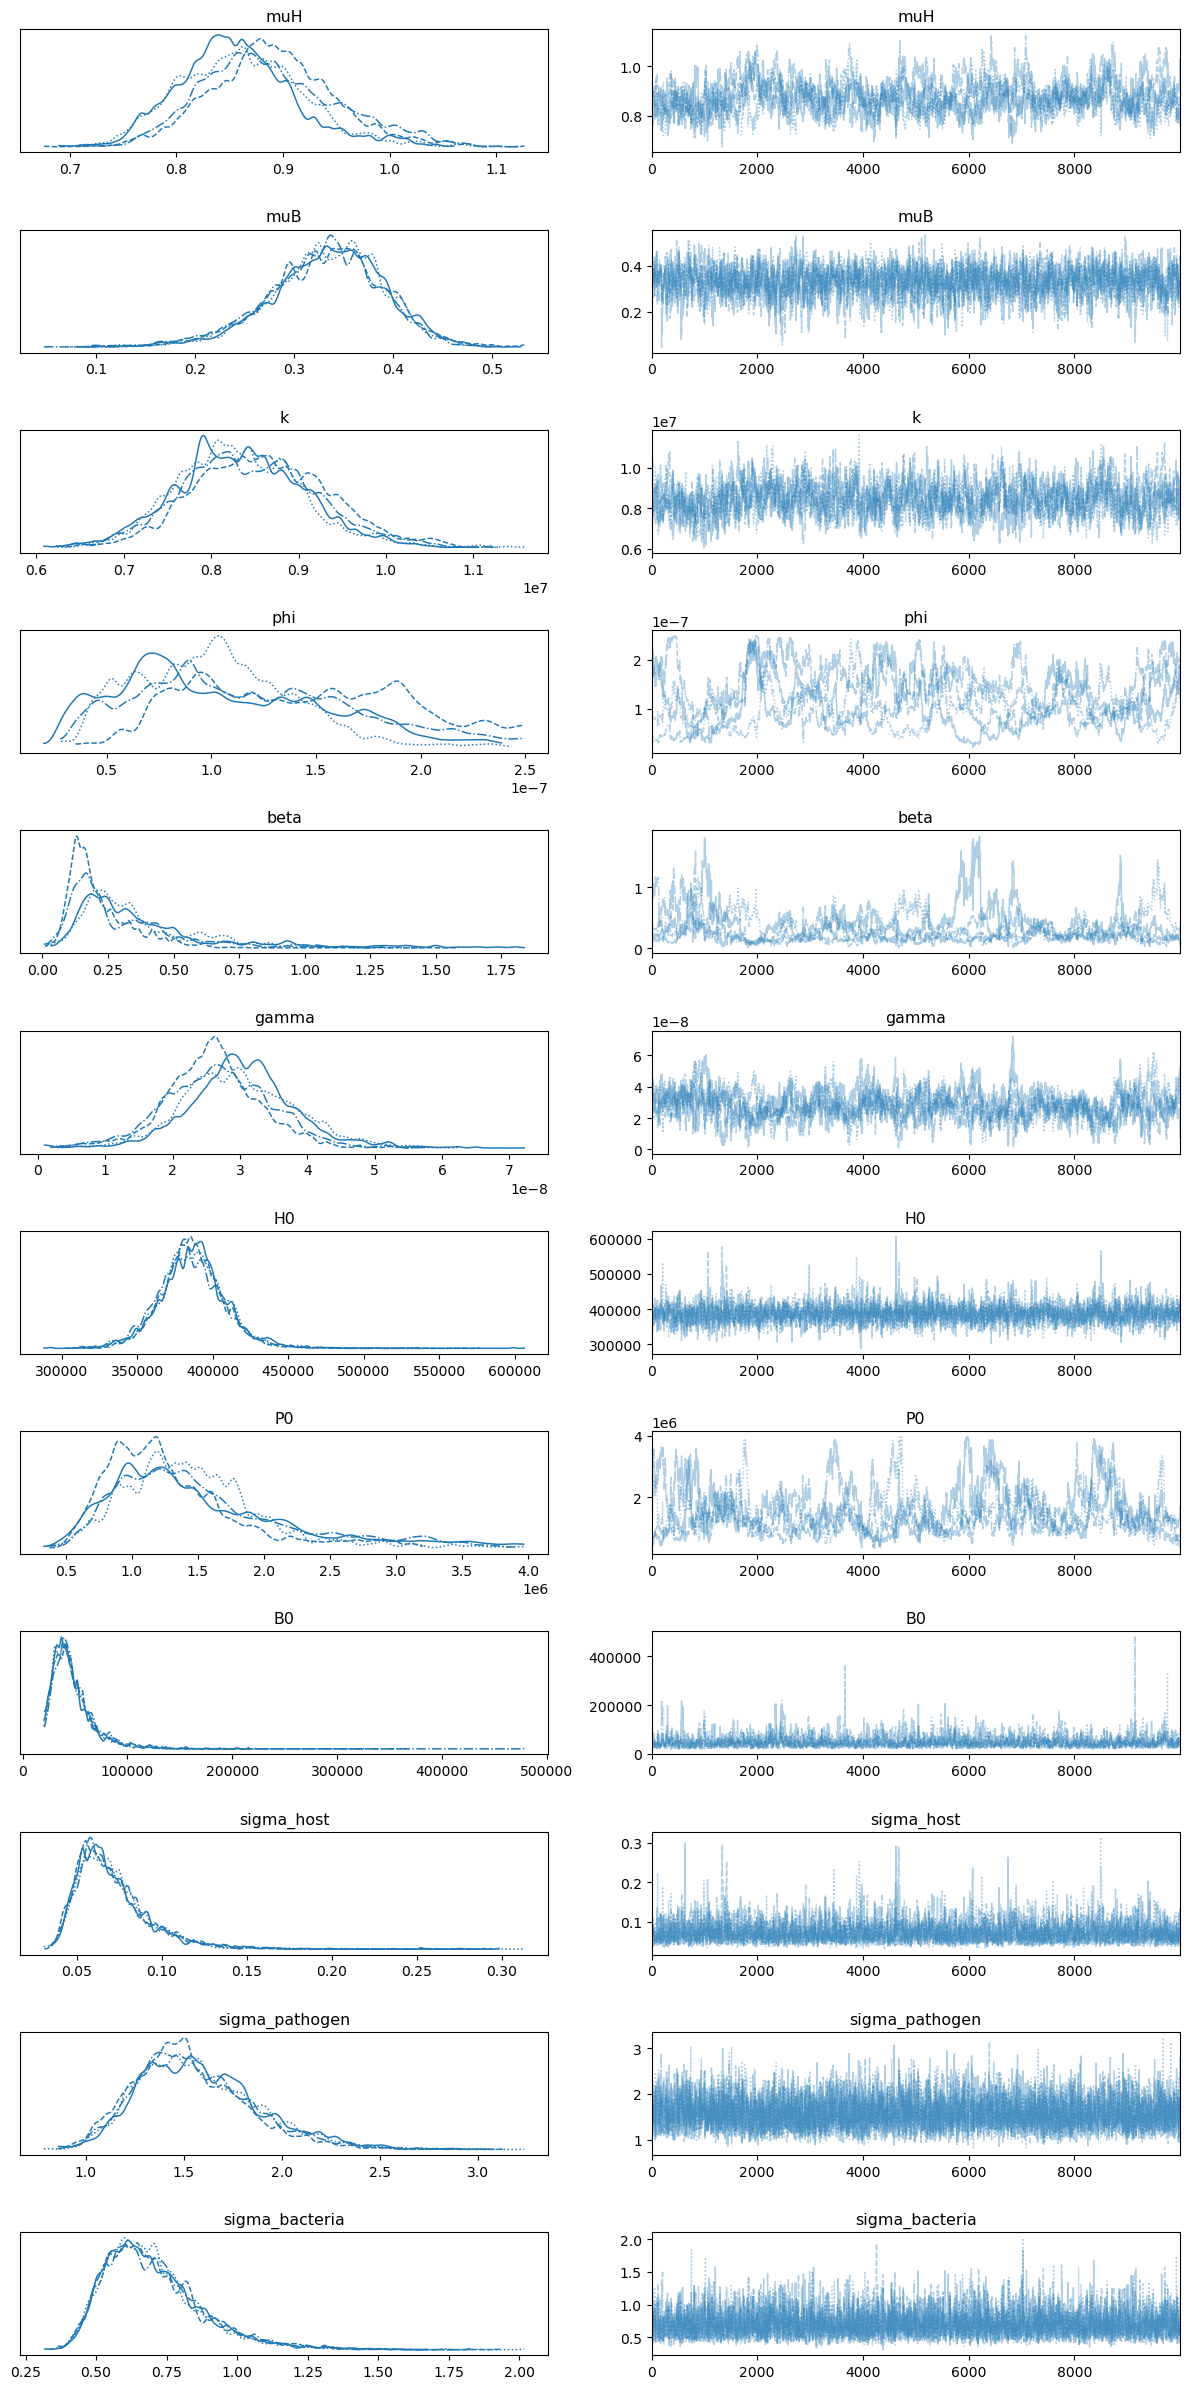

In [18]:
az.plot_trace(trace, 
              var_names=["muH", "muB", "k", "phi", "beta", "gamma", "H0", "P0", "B0", "sigma_host", "sigma_pathogen", "sigma_bacteria"],
              backend_kwargs={"tight_layout": True})

## SOME GPT5 Post Processing

In [51]:
def simulate_ode_from_posterior(
    idata,
    time,
    ode_rhs,
    n_draws=100,
    random_seed=None,
):
    import numpy as np
    import arviz as az
    from scipy.integrate import solve_ivp

    rng = np.random.default_rng(random_seed)

    posterior = idata.posterior
    n_chains = posterior.sizes["chain"]
    n_draws_posterior = posterior.sizes["draw"]

    flat_idx = rng.integers(0, n_chains * n_draws_posterior, size=n_draws)
    chain_idx = flat_idx // n_draws_posterior
    draw_idx = flat_idx % n_draws_posterior

    time = np.asarray(time, dtype=float)
    t_span = (time[0], time[-1])

    sims = []

    for c, d in zip(chain_idx, draw_idx):
        muH0 = float(posterior["muH"].values[c, d])
        muB0 = float(posterior["muB"].values[c, d])
        k0      = float(posterior["k"].values[c, d])
        phi0    = float(posterior["phi"].values[c, d])
        beta0  = float(posterior["beta"].values[c, d])

        H00 = float(posterior["H0"].values[c, d])
        P00 = float(posterior["P0"].values[c, d])
        B00 = float(posterior["B0"].values[c, d])

        params_vec = np.array([muH0, muB0, k0, phi0, beta0], dtype=float)
        y0 = [H00, P00, B00]

        sol = solve_ivp(
            lambda t, y: ode_rhs(t, y, params_vec),
            t_span=t_span,
            y0=y0,
            t_eval=time,
            method="LSODA",   # or whatever stiff solver you like
            rtol=1e-6,
            atol=1e-8,
        )

        if not sol.success:
            sims.append(np.full((time.size, 3), np.nan))
        else:
            sims.append(sol.y.T)

    sims = np.stack(sims, axis=0)  # (n_draws, T, 3)
    return sims


In [52]:
import matplotlib.pyplot as plt

def plot_posterior_fit(
    idata,
    time,
    host,
    d7,
    bacteria,
    ode_rhs,
    n_draws=200,
    log_scale=True,
    random_seed=None,
):
    """
    Plot posterior ODE trajectories over the observed data
    for Host, D7/Pathogen, and Bacteria.
    """
    time = np.asarray(time, dtype=float)
    host = np.asarray(host, dtype=float)
    d7 = np.asarray(d7, dtype=float)
    bacteria = np.asarray(bacteria, dtype=float)

    sims = simulate_ode_from_posterior(
        idata,
        time,
        ode_rhs,
        n_draws=n_draws,
        random_seed=random_seed,
    )  # (n_draws, T, 3)

    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 10))

    series = [host, d7, bacteria]
    labels = ["Host", "Pathogen (D7)", "Bacteria"]

    for i, ax in enumerate(axes):
        y_obs = series[i]
        y_sim = sims[:, :, i]  # (n_draws, T)

        if log_scale:
            y_obs_plot = np.log(y_obs + 1e-9)
            y_sim_plot = np.log(y_sim + 1e-9)
            ax.set_ylabel(f"log {labels[i]}")
        else:
            y_obs_plot = y_obs
            y_sim_plot = y_sim
            ax.set_ylabel(labels[i])

        # scatter observed data
        ax.scatter(time, y_obs_plot, marker="o", alpha=0.8)

        # posterior median and 90% band
        median = np.nanmedian(y_sim_plot, axis=0)
        lower, upper = np.nanpercentile(y_sim_plot, [5, 95], axis=0)

        ax.plot(time, median, linewidth=2)
        ax.fill_between(time, lower, upper, alpha=0.2)

        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel("Time")
    plt.tight_layout()
    return fig, axes


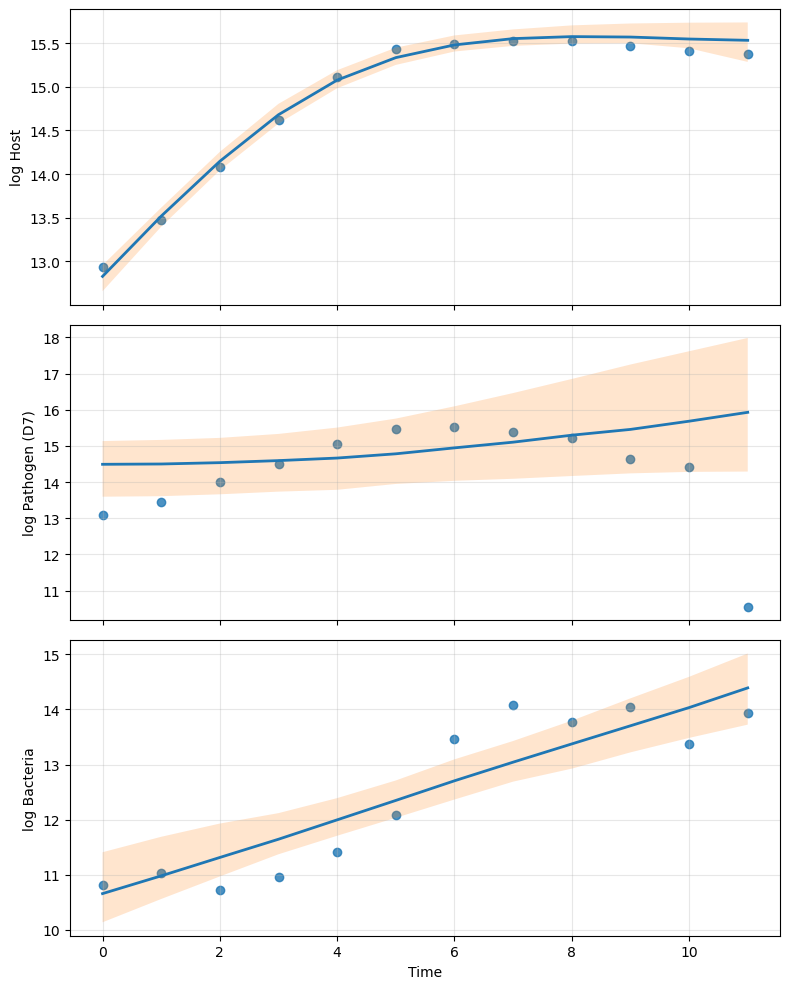

In [53]:
fig, axes = plot_posterior_fit(
    idata=trace,
    time=time,
    host=host,
    d7=d7,
    bacteria=bacteria,
    ode_rhs=ode_system,
    n_draws=200,
    log_scale=True,
    random_seed=42,
)
